# Plant function vs microbial community composition

Test principle components from growth residuals on microbial community composition using constrained analysis of principle components

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(Hmisc)
library(lme4)
library(lmerTest)
library(ggplot2)
library(dplyr)
library(tidyr)
library(pbkrtest)
library(gridExtra)
library(reshape2)
library(picante)
library(ape)
library(DESeq2)
library(phyloseq)
library(doParallel)



/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattice

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: survival

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: Formula

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: ggplot2

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘Hmisc’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: 

In [3]:
%%R

log2foldFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/bare-plant.csv'
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3')

physeq.Full = readRDS(F)

# read rhizosphere log2fold change file and 
l2f = read.csv(log2foldFile, header = TRUE) 
l2f = l2f[l2f$p.adj < .05,]
resp = l2f$OTU %>% unique %>% as.character
l2f = NULL

phy = filter_taxa(physeq.Full, function(x) sum(x > 0) > 0, TRUE)
phy = prune_taxa(resp, phy)
phy = subset_samples(phy, Plant != "BARE")
phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1506 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 1506 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1506 tips and 1505 internal nodes ]


# Try ordination on pruned rhizosphere responder dataset

In [4]:
%%R
# Try PCoA 

ordu = ordinate(phy, "PCoA", "unifrac", weighted=TRUE)
p = plot_ordination(phy, ordu, color="Plant", shape="Type") 

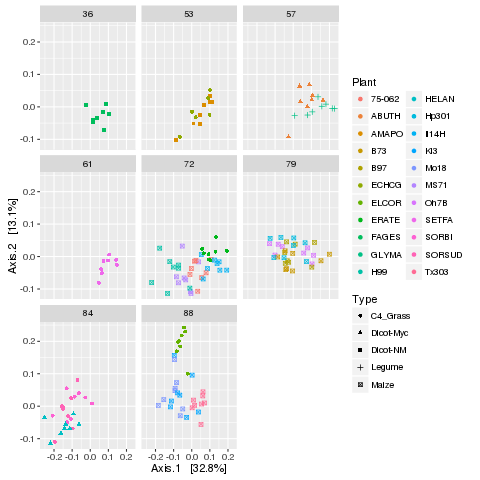

In [5]:
%%R
p + facet_wrap(~DAP)

# Annuals 

## Late Season Annuals - PCA of growth residuals

   Plant SeedSize_mg
1  ERATE      0.0035
2  HELAN          90
3    B73         333
4  FAGES          38
5  AMAPO        0.49
6 SORSUD        10.7
NULL
Importance of components:
                          PC1    PC2     PC3     PC4
Standard deviation     1.4973 1.1837 0.59627 0.03612
Proportion of Variance 0.5605 0.3503 0.08888 0.00033
Cumulative Proportion  0.5605 0.9108 0.99967 1.00000
                        PC1         PC2        PC3         PC4
log(SeedSize_mg) -0.5549666  0.24710822 -0.7936365 -0.03302717
A_Resid_logB     -0.6461202 -0.05649449  0.4074687  0.64288904
A_Resid_logN     -0.4687695 -0.59539147  0.1686459 -0.63033538
A_Resid_logCN    -0.2340853  0.76240075  0.4191288 -0.43391266


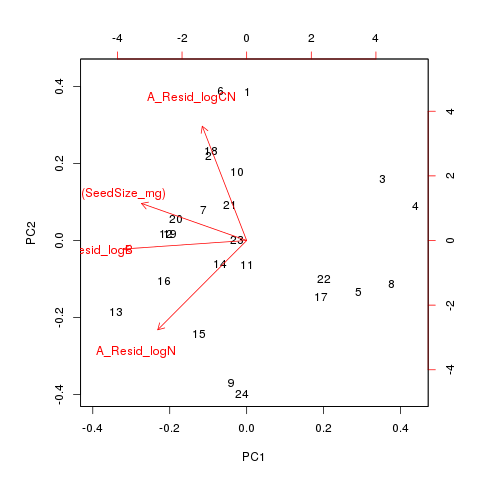

In [6]:
%%R
# PCA of annuals



# subset of plants for which functional variation was significant
LS = subset_samples(phy, Treatment == "Nneg" & Plant %in% c("B73",   "ERATE", 
 "ELCOR",  "SORSUD",    "SORBI", "HELAN") )


# Add seed size information
Plant = c("ERATE", "HELAN", "B73", "FAGES", "AMAPO", "SORSUD", "SORBI", 
          "ELCOR", "ECHCG", "ABUTH", "SETFA", "GLYMA", "MS71", "Mo18", "Il14H", "Tx303", "Oh7B",
         "B97", "Hp301", "75-062", "Ki3", "H99")
                    
SeedSize_mg = c(.0035, 90, 333, 38, .49, 10.7, 32.39,
               3.2, 1.58, 9.6, 1.8, 174, .264, .224, 0.219, 0.279, 0.207,
               0.240, 0.0869, 0.222, 0.228, 0.231)


SS = cbind(Plant, SeedSize_mg) %>% as.data.frame
head(SS) %>% print
SS$SeedSize_mg = SS$SeedSize_mg %>% as.character %>% as.numeric


sd = as(sample_data(LS), "data.frame")

sd = left_join(sd, SS, by = "Plant")

sd$Plant %>% levels %>% print


fit = prcomp(~log(SeedSize_mg) + A_Resid_logB + A_Resid_logN + A_Resid_logCN, data = sd, 
                na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)





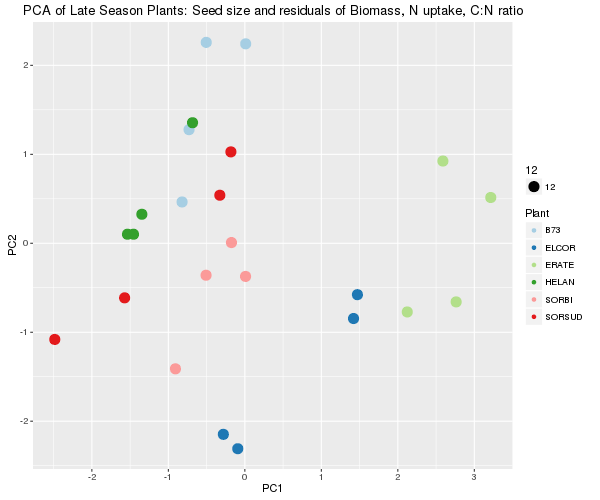

In [12]:
%%R -w 600 -h 500
S = predict(fit)[,1:3]
TM_Fit = cbind(sd, S)
rownames(TM_Fit) = TM_Fit$X.sample
sample_data(LS) = TM_Fit



p = ggplot(TM_Fit, aes(PC1, PC2, colour = Plant, 
                       size = 12), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Late Season Plants: Seed size and residuals of Biomass, N uptake, C:N ratio")
p

Notes: 
    * PC2 represents residual C:N ratio once plant size, total N uptake and seed size are controlled for
    * Species effect apparent in both PC1 and PC2

## Annuals CAP with principle components

In [9]:
%%R
# Calculate w-unifrac distances
registerDoParallel(cores=28)
LS.wunif.dist = phyloseq::distance(LS, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


[1] 79 72 88 84
Levels: 72 79 84 88
Permutation test for capscale under reduced model
Permutation: free
Number of permutations: 999

Model: capscale(formula = distance ~ PC1 + PC2 + Condition(Library), data = data)
         Df SumOfSqs      F Pr(>F)    
Model     2  0.26138 4.7608  0.001 ***
Residual 20  0.54902                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


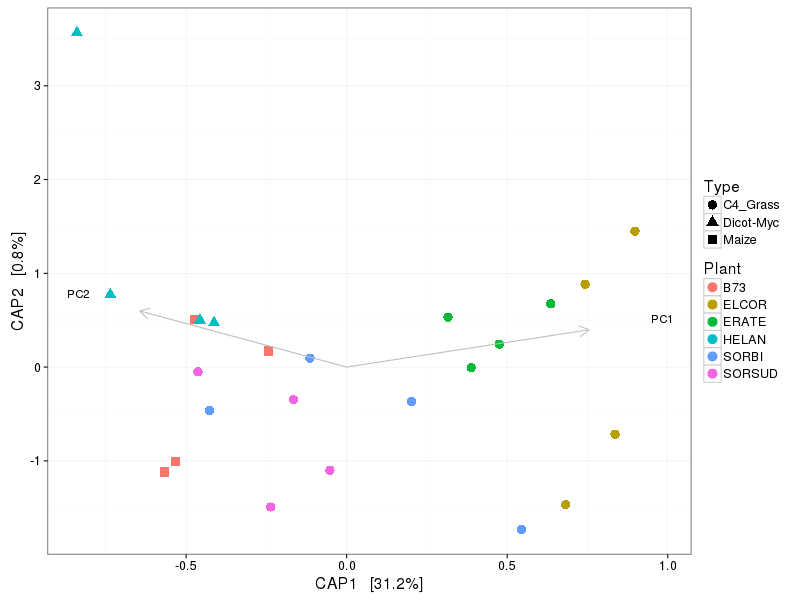

In [10]:
%%R -w 800 -h 600

dist = LS.wunif.dist

sample_data(LS)$DAP = as.factor(sample_data(LS)$DAP)
unique(sample_data(LS)$DAP) %>% print

#Weighted unifrac CAP

        # CAP ordinate
        cap.ord = ordinate(
            physeq = LS, 
            method = "CAP",
            distance = dist,
            formula = ~ PC1 + PC2 + Condition(Library)
        )

        # CAP plot
        cap.plot <- plot_ordination(
            LS, 
            cap.ord, 
            color = "Plant", 
            axes = c(1,2)
            ) + 
            aes(shape = Type) + 
            geom_point(aes(colour = Plant), 
                alpha= 1, 
                size = 4) + 
            #geom_point(colour = "grey90", 
            #    size = 1.5) + 
            theme_bw(base_size = 16)
            #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
            #    "#1919ff", "darkorchid3", "magenta"))


        # Now add the environmental variables as arrows
        arrowmat <- vegan::scores(cap.ord, display = "bp")


        # Add labels, make a data.frame
        arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

        # Define the arrow aesthetic mapping
        arrow_map <- aes(xend = CAP1, 
            yend = CAP2, 
            x = 0, 
            y = 0, 
            shape = NULL, 
            color = NULL, 
            label = labels)

        label_map <- aes(x = 1.3 * CAP1, 
            y = 1.3 * CAP2, 
            shape = NULL, 
            color = NULL, 
            label = labels)

        arrowhead = arrow(length = unit(0.02, "npc"))

        # Make a new graphic
        p1 = cap.plot + 
            geom_segment(arrow_map, 
                size = .5, 
                data = arrowdf, 
                color = "gray", 
                arrow = arrowhead
                ) + 
            geom_text(label_map, 
                size = 4,  
                data = arrowdf, 
                show_guide = FALSE)

anova(cap.ord) %>% print
p1


Notes:
* PC1 and PC2 describes 15.7% of variation in microbial community weighted unifrac distance
* CAP analysis is significant p < 0.001

## Try CAP with Enzyme info as well

[1] 79 72 88 84
Levels: 72 79 84 88
Permutation test for capscale under reduced model
Permutation: free
Number of permutations: 999

Model: capscale(formula = distance ~ PC1 + PC2 + PC3 + Condition(Library), data = data)
         Df SumOfSqs      F Pr(>F)    
Model     3  0.33375 4.4347  0.001 ***
Residual 19  0.47665                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


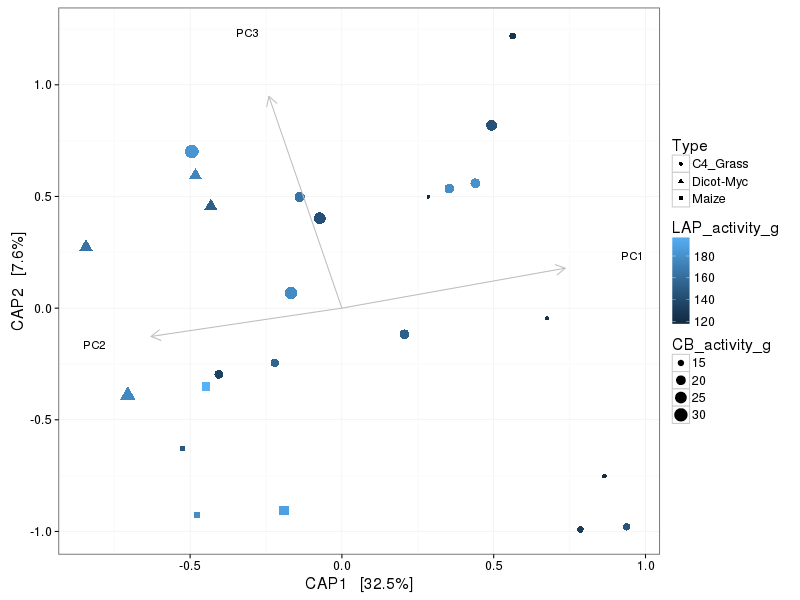

In [30]:
%%R -w 800 -h 600

dist = LS.wunif.dist

sample_data(LS)$DAP = as.factor(sample_data(LS)$DAP)
unique(sample_data(LS)$DAP) %>% print

#Weighted unifrac CAP

        # CAP ordinate
        cap.ord = ordinate(
            physeq = LS, 
            method = "CAP",
            distance = dist,
            formula = ~ PC1 + PC2 + PC3 + Condition(Library)
        )

        # CAP plot
        cap.plot <- plot_ordination(
            LS, 
            cap.ord, 
            color = "LAP_activity_g", 
            axes = c(1,2)
            ) + 
            aes(shape = Type) + 
            geom_point(aes(fill = LAP_activity_g, size = CB_activity_g), 
                alpha= 1) + 
            #geom_point(colour = "grey90", 
            #    size = 1.5) + 
            theme_bw(base_size = 16)
            #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
            #    "#1919ff", "darkorchid3", "magenta"))


        # Now add the environmental variables as arrows
        arrowmat <- vegan::scores(cap.ord, display = "bp")


        # Add labels, make a data.frame
        arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

        # Define the arrow aesthetic mapping
        arrow_map <- aes(xend = CAP1, 
            yend = CAP2, 
            x = 0, 
            y = 0, 
            shape = NULL, 
            color = NULL, 
            label = labels)

        label_map <- aes(x = 1.3 * CAP1, 
            y = 1.3 * CAP2, 
            shape = NULL, 
            color = NULL, 
            label = labels)

        arrowhead = arrow(length = unit(0.02, "npc"))

        # Make a new graphic
        p1 = cap.plot + 
            geom_segment(arrow_map, 
                size = .5, 
                data = arrowdf, 
                color = "gray", 
                arrow = arrowhead
                ) + 
            geom_text(label_map, 
                size = 4,  
                data = arrowdf, 
                show_guide = FALSE)

anova(cap.ord) %>% print
p1

## How does unconstrained PCoA place these microbial communities

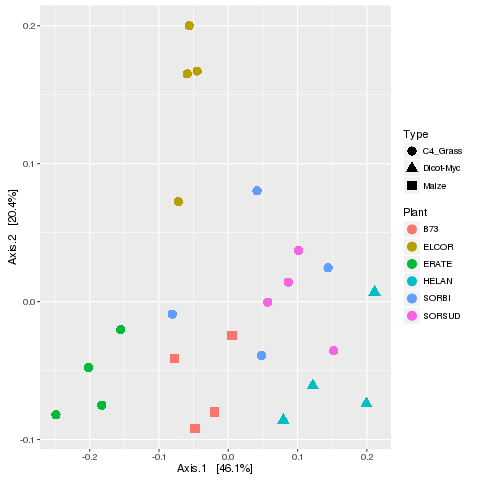

In [37]:
%%R
ordu = ordinate(LS, "PCoA", "unifrac", weighted=TRUE)
p = plot_ordination(LS, ordu, color="Plant", shape="Type") 
p = p + geom_point(size = 4)
p

##  Late Season Annuals Deseq of PC2
* Identify OTUs that vary with PC2

In [11]:
%%R
dds = phyloseq_to_deseq2(LS, ~Library + PC1)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(LS)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: estimating size factors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: estimating dispersions

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/fu

[1] "Intercept" "Library"   "PC1"      


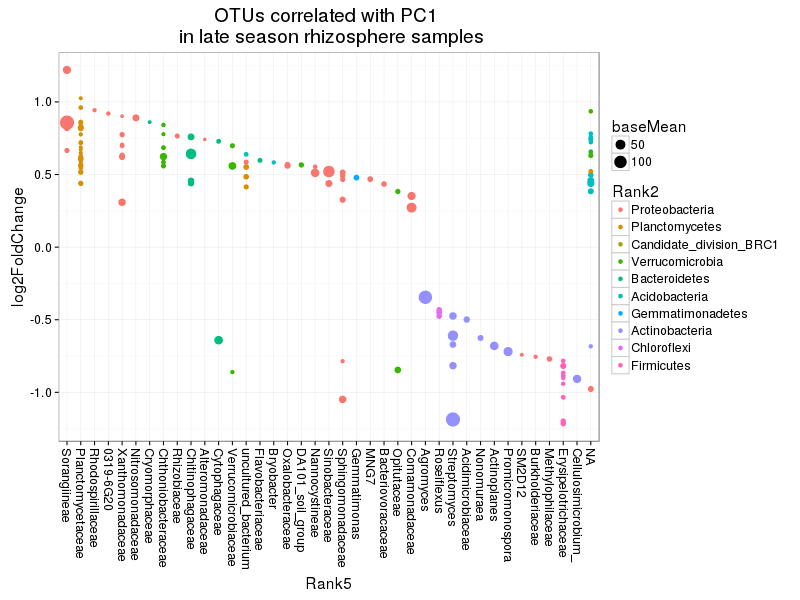

In [14]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs correlated with PC1 \n in late season rhizosphere samples")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
    p2

In [15]:
%%R
cat(dim(sigtab)[1], "OTUs vary significantly with PC1")

131 OTUs vary significantly with PC1

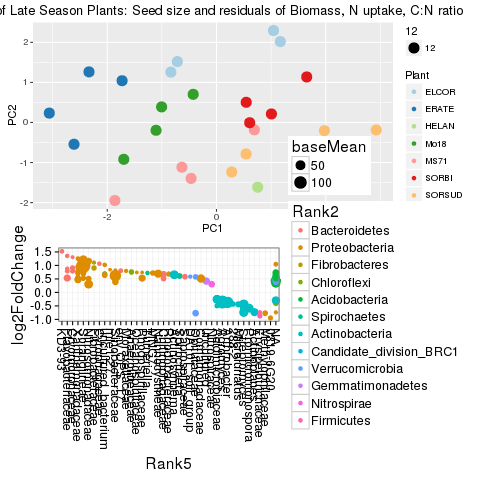

In [33]:
%%R
grid.arrange(p,p2, layout_matrix = rbind(c(1), c(2,2)))

## Late season Annuals - Deseq of Time /DAP

In [17]:
%%R
dds = phyloseq_to_deseq2(LS, ~Library + PC1 + DAP)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(LS)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

[1] "Intercept" "Library"   "PC1"       "DAP"      


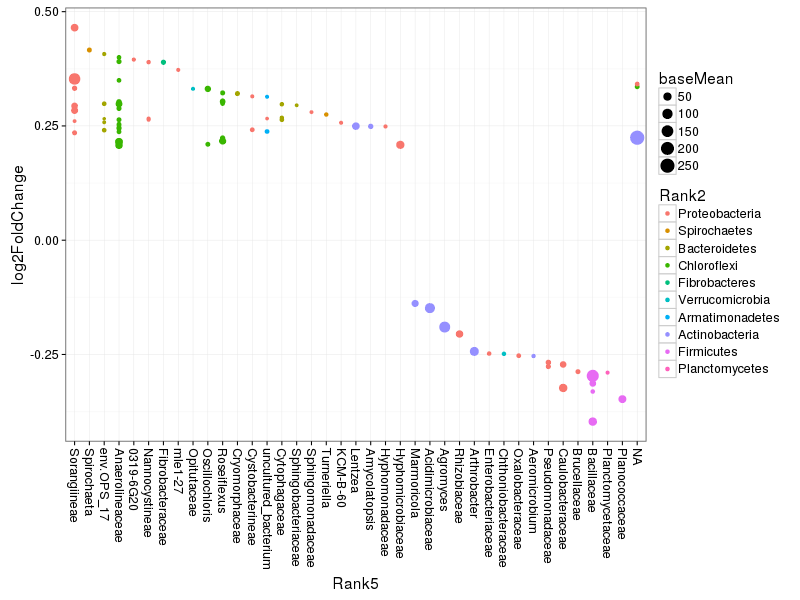

In [18]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

In [19]:
%%R
cat(dim(sigtab)[1], "OTUs vary significantly with DAP")

90 OTUs vary significantly with DAP

## All Plants - CAP of functional traits

In [43]:
%%R
phy.neg = subset_samples(physeq.Full, Plant != "BARE"  & Treatment == "Nneg")
#sample_data(phy)$TimeClass = cut(sample_data(phy)$DAP, breaks = c(35,38, 62, 89), labels = c("A", "B", "C"))
#sample_data(phy)[,c("DAP", "TimeClass")]

   Plant SeedSize_mg
1  ERATE      0.0035
2  HELAN          90
3    B73         333
4  FAGES          38
5  AMAPO        0.49
6 SORSUD        10.7
 [1] "75-062" "ABUTH"  "AMAPO"  "B73"    "B97"    "ECHCG"  "ELCOR"  "ERATE" 
 [9] "FAGES"  "GLYMA"  "H99"    "HELAN"  "Hp301"  "Il14H"  "Ki3"    "Mo18"  
[17] "MS71"   "Oh7B"   "SETFA"  "SORBI"  "SORSUD" "Tx303" 
Importance of components:
                         PC1    PC2    PC3     PC4
Standard deviation     1.527 1.0247 0.7848 0.04564
Proportion of Variance 0.583 0.2625 0.1540 0.00052
Cumulative Proportion  0.583 0.8455 0.9995 1.00000
                        PC1        PC2        PC3          PC4
log(SeedSize_mg)  0.4375562 -0.3576541 -0.8249996 -0.001934066
A_Resid_logB      0.5769273 -0.3138561  0.4406140  0.611971036
A_Resid_logN      0.6312646  0.1535568  0.2699008 -0.710689000
A_Resid_logCN    -0.2778570 -0.8660244  0.2288852 -0.346999792


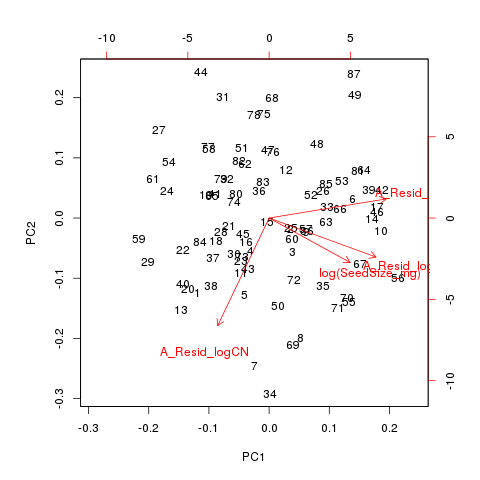

In [46]:
%%R
# PCA of all plants

# Add seed size information
Plant = c("ERATE", "HELAN", "B73", "FAGES", "AMAPO", "SORSUD", "SORBI", 
          "ELCOR", "ECHCG", "ABUTH", "SETFA", "GLYMA", "MS71", "Mo18", "Il14H", "Tx303", "Oh7B",
         "B97", "Hp301", "75-062", "Ki3", "H99")
                    
SeedSize_mg = c(.0035, 90, 333, 38, .49, 10.7, 32.39,
               3.2, 1.58, 9.6, 1.8, 174, .264, .224, 0.219, 0.279, 0.207,
               0.240, 0.0869, 0.222, 0.228, 0.231)


SS = cbind(Plant, SeedSize_mg) %>% as.data.frame
head(SS) %>% print
SS$SeedSize_mg = SS$SeedSize_mg %>% as.character %>% as.numeric


sd = as(sample_data(phy.neg), "data.frame")

sd = left_join(sd, SS, by = "Plant")

sd$Plant %>% levels %>% print


fit = prcomp(~log(SeedSize_mg) + A_Resid_logB + A_Resid_logN + A_Resid_logCN, data = sd, 
                na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)





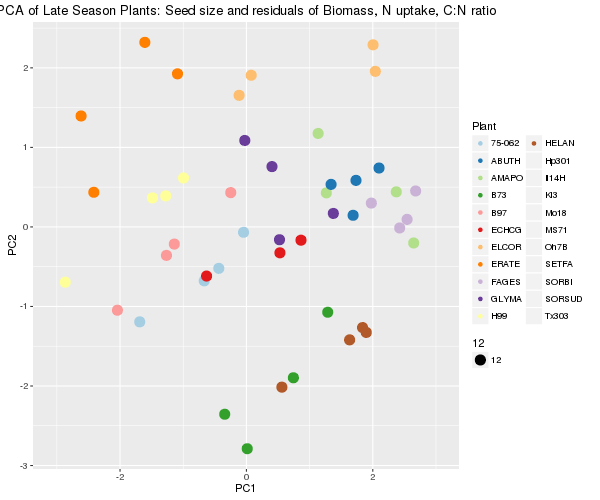

In [47]:
%%R -w 600 -h 500
S = predict(fit)[,1:3]
TM_Fit = cbind(sd, S)
rownames(TM_Fit) = TM_Fit$X.sample
sample_data(phy.neg) = TM_Fit



p = ggplot(TM_Fit, aes(PC1, PC2, colour = Plant, 
                       size = 12), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Late Season Plants: Seed size and residuals of Biomass, N uptake, C:N ratio")
p

In [48]:
%%R
# Calculate w-unifrac distances
registerDoParallel(cores=28)
wunif.dist = phyloseq::distance(phy.neg, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


[1] 72 61 36 79 53 57 88 84
Levels: 36 53 57 61 72 79 84 88
Permutation test for capscale under reduced model
Permutation: free
Number of permutations: 999

Model: capscale(formula = distance ~ PC1 + PC2 + PC3 + Condition(Library), data = data)
         Df SumOfSqs     F Pr(>F)    
Model     3  0.27814 3.679  0.001 ***
Residual 82  2.06644                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


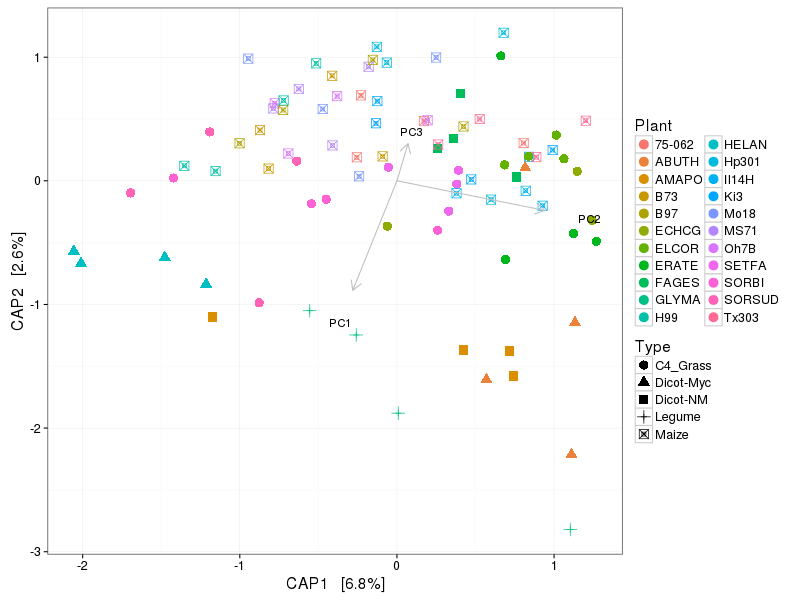

In [50]:
%%R -w 800 -h 600

dist = wunif.dist

sample_data(phy.neg)$DAP = as.factor(sample_data(phy.neg)$DAP)
unique(sample_data(phy.neg)$DAP) %>% print

#Weighted unifrac CAP

        # CAP ordinate
        cap.ord = ordinate(
            physeq = phy.neg, 
            method = "CAP",
            distance = dist,
            formula = ~ PC1 + PC2 + PC3 + Condition(Library)
        )

        # CAP plot
        cap.plot <- plot_ordination(
            phy.neg, 
            cap.ord, 
            color = "Plant", 
            axes = c(1,2)
            ) + 
            aes(shape = Type) + 
            geom_point(aes(colour = Plant), 
                alpha= 1, 
                size = 4) + 
            #geom_point(colour = "grey90", 
            #    size = 1.5) + 
            theme_bw(base_size = 16)
            #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
            #    "#1919ff", "darkorchid3", "magenta"))


        # Now add the environmental variables as arrows
        arrowmat <- vegan::scores(cap.ord, display = "bp")


        # Add labels, make a data.frame
        arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

        # Define the arrow aesthetic mapping
        arrow_map <- aes(xend = CAP1, 
            yend = CAP2, 
            x = 0, 
            y = 0, 
            shape = NULL, 
            color = NULL, 
            label = labels)

        label_map <- aes(x = 1.3 * CAP1, 
            y = 1.3 * CAP2, 
            shape = NULL, 
            color = NULL, 
            label = labels)

        arrowhead = arrow(length = unit(0.02, "npc"))

        # Make a new graphic
        p1 = cap.plot + 
            geom_segment(arrow_map, 
                size = .5, 
                data = arrowdf, 
                color = "gray", 
                arrow = arrowhead
                ) + 
            geom_text(label_map, 
                size = 4,  
                data = arrowdf, 
                show_guide = FALSE)

anova(cap.ord) %>% print
p1


## All plants - Deseq of Time 

In [ ]:
%%R

dds = phyloseq_to_deseq2(phy.neg, ~Library +  poly(DAP,2))
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

In [ ]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
    #ggtitle("2nd order polynomial") +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

In [ ]:
%%R

DF.C = results(d_dds, name = "poly.DAP..2.1")

supp = tax_table(physeq.Full)
            if (!setequal(row.names(supp), row.names(DF.C))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF.C), row.names(supp)))
        }  

        DF.C = data.frame(DF.C, supp)
        DF.C$OTU = rownames(DF.C)

In [ ]:
%%R -w 800 -h 600
sigtabC = DF.C %>% filter(padj < 0.05)
x = tapply(sigtabC$log2FoldChange, sigtabC$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtabC$Rank2 = factor(as.character(sigtabC$Rank2), levels=names(x))
x = tapply(sigtabC$log2FoldChange, sigtabC$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtabC$Rank5 = factor(as.character(sigtabC$Rank5), levels=names(x))
    
ggplot(sigtabC, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
    ggtitle("1st order polynomial")+
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x


In [ ]:
%%R
head(DF)
colnames(DF) = paste(colnames(DF),".2", sep ="")
colnames(DF.C) = paste(colnames(DF.C),".1", sep ="")

In [ ]:
%%R
L2F.DAP = full_join(DF.C, DF[,c(1:6, 15)], by = c("OTU.1" = "OTU.2"))
dim(L2F.DAP) %>% print
head(L2F.DAP)


In [ ]:
%%R
sigtab = filter(L2F.DAP, padj.1 < 0.05 | padj.2 < 0.05)
cat(dim(sigtab)[1], "OTUs vary significantly with DAP")

In [ ]:
%%R
head(sigtab)

In [ ]:
%%R
#all significant OTUs
AllSig = sigtab$OTU.1

#OTUs with significant 1st order polynomial positive log 2 fold
sigtab.1 = filter(sigtab, log2FoldChange.1 > 0) %>% arrange(padj.1)
dim(sigtab.1) %>% print
rownames(sigtab.1) = sigtab.1$OTU.1 
Top10.1 = sigtab.1[1:10, "OTU.1"] #%>% row.names
Top10.1 %>% print

sigtab.1neg = filter(sigtab, log2FoldChange.1 < 0) %>% arrange(padj.1)
dim(sigtab.1neg) %>% print
rownames(sigtab.1neg) = sigtab.1neg$OTU.1 
Top10.1neg = sigtab.1neg[1:10, "OTU.1"] #%>% row.names
Top10.1neg %>% print

sigtab.2 = filter(sigtab, padj.2 < 0.05) %>% arrange(padj.2)
dim(sigtab.2) %>% print
rownames(sigtab.2) = sigtab.2$OTU.2 
Top10.2 = sigtab.2[, "OTU.1"] #%>% row.names
Top10.2 %>% print


# sigtab.2neg = filter(sigtab, log2FoldChange.2 < 0) %>% arrange(padj.2)
# dim(sigtab.2neg) %>% print
# rownames(sigtab.2neg) = sigtab.2neg$OTU.2 
# Top10.2neg = sigtab.2neg[1:10, "OTU.1"] #%>% row.names
# Top10.2neg %>% print

# physub = prune_taxa(Top20, phy) %>%  merge_samples("DAP")
# physub


In [ ]:
%%R
# create new deseq object with DAP as factor
phy = subset_samples(physeq.Full, Plant != "BARE")
phy = prune_taxa(AllSig, phy) %>% filter_taxa(function(x) max(x) > 100, TRUE)
phy

In [ ]:
%%R
# phy
sample_data(phy)$DAP = as.factor(sample_data(phy)$DAP)
dds = phyloseq_to_deseq2(phy, ~Library + DAP)
d_dds = DESeq(dds, parallel = TRUE)

In [ ]:
%%R
tax_table(phy) %>% row.names

In [ ]:
%%R -w 800 -h 1200
p <- list()
Tinfo = as(tax_table(phy), "matrix")
ToGraph = tax_table(phy) %>% row.names
for (i in ToGraph){
  d = plotCounts(dds, gene=i, intgroup=c("DAP", "Type"), returnData = TRUE)  
    
    
p[[i]] = ggplot(d, aes(x=DAP, y=count, color = Type)) +
  geom_point(position=position_jitter(w=0.1,h=0)) +
  theme(legend.position="none") +
    ggtitle(paste(i, "\n", Tinfo[i, 2], ": ", Tinfo[i, 6], sep = ""))
  }

#legend = get_legend(p[1])
do.call(grid.arrange,c(p, ncol = 4))
#

In [ ]:
%%R -w 800 -h 1000
p <- list()
for (i in Top10.1neg){
  d = plotCounts(dds, gene=i, intgroup=c("DAP", "Type"), returnData = TRUE)  
p[[i]] = ggplot(d, aes(x=DAP, y=count, color = Type)) +
  geom_point(position=position_jitter(w=0.1,h=0)) +
  theme(legend.position="none") +
    ggtitle(paste(i, "\n", Tinfo[i, 2], "\n", Tinfo[i, 6], sep = ""))
  }

#legend = get_legend(p[1])
do.call(grid.arrange,p)
#

In [ ]:
%%R -w 800 -h 1200
p <- list()
for (i in Top10.2){
  d = plotCounts(dds, gene=i, intgroup=c("DAP", "Type"), returnData = TRUE)  
p[[i]] = ggplot(d, aes(x=DAP, y=count, color = Type)) +
  geom_point(position=position_jitter(w=0.1,h=0)) +
  theme(legend.position="none") +
    ggtitle(paste(i, "\n", Tinfo[i, 2], "\n", Tinfo[i, 6], sep = ""))
  }

#legend = get_legend(p[1])
do.call(grid.arrange,p)
#

In [ ]:
%%R
p <- list()
for (i in Top10.2neg){
  d = plotCounts(dds, gene=i, intgroup=c("DAP", "Type"), returnData = TRUE)  
p[[i]] = ggplot(d, aes(x=DAP, y=count, color = Type)) +
  geom_point(position=position_jitter(w=0.1,h=0)) +
  theme(legend.position="none") +
    ggtitle(paste(i))
  }

#legend = get_legend(p[1])
do.call(grid.arrange,p)
#

In [ ]:
%%R
for (i in Top10.2){
p =  plotCounts(dds, gene=i, intgroup=c("DAP", "Plant"))  

}

In [ ]:
%%R -w 800 -h 400
library("scales")
d = plotCounts(dds, gene= "OTU.3", intgroup=c("DAP", "Plant"), returnData=TRUE)  
d = arrange(d, "DAP")
p = ggplot(d, aes(x = Plant, y = count)) + 
geom_point() +
scale_y_continuous(trans=log2_trans())

d = NULL
p 

In [ ]:
%%R
physeq.Full %>% tax_table %>% .[c("OTU.197", "OTU.101", "OTU.5", "OTU.271", "OTU.45", "OTU.10249", "OTU.3"), ]

In [ ]:
%%R
p = plot_bar(physub, "DAP", fill="Rank6")
p = p + facet_wrap(~OTU, ncol = 4, scales = "free_y")
p

In [ ]:
%%R
T = prune_taxa("OTU.1668", phy) %>% merge_samples("Plant")
p = plot_bar(T)
#p = p + facet_wrap(~OTU, ncol = 4, scales = "free_y")
p

## Panicoideae - Deseq of Time 

In [38]:
%%R
phy = subset_samples(physeq.Full, Plant %in% c("ECHCG", "SETFA", "MS71", "Mo18", "SORBI", "SORSUD", "ERATE", "ELCOR") & Treatment == "Nneg")
#sample_data(phy)$TimeClass = cut(sample_data(phy)$DAP, breaks = c(35,38, 62, 89), labels = c("A", "B", "C"))
#sample_data(phy)[,c("DAP", "TimeClass")]

In [39]:
%%R

dds = phyloseq_to_deseq2(phy, ~Library +  DAP)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: -- replacing outliers and refitting for 68 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: fitting model and testing

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[1] "Intercept" "Library"   "DAP"      


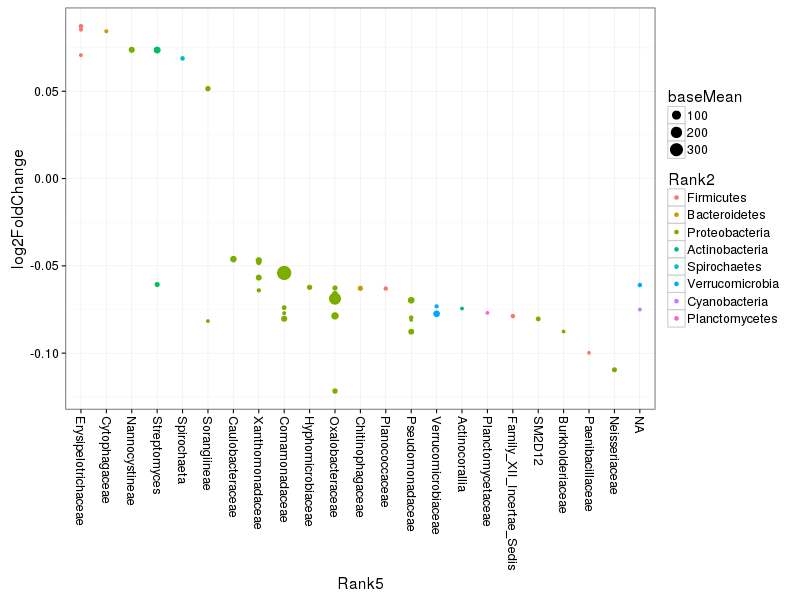

In [40]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
    #ggtitle("2nd order polynomial") +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

In [ ]:
%%R

# DF.1 = results(d_dds, name = "poly.DAP..2.1")

# supp = tax_table(physeq.Full)
#             if (!setequal(row.names(supp), row.names(DF.1))) {
#             stop("Ordination and supplementary data indices differ on the following:\n.",
#             setdiff(row.names(DF.1), row.names(supp)))
#         }  

#         DF.1 = data.frame(DF.1, supp)
#         DF.1$OTU = rownames(DF.1)

In [ ]:
%%R -w 800 -h 600
# sigtab1 = DF.1 %>% filter(padj < 0.05)
# x = tapply(sigtab1$log2FoldChange, sigtab1$Rank2, function(x) max(x))
# x = sort(x, TRUE)
# sigtab1$Rank2 = factor(as.character(sigtab1$Rank2), levels=names(x))
# x = tapply(sigtab1$log2FoldChange, sigtab1$Rank5, function(x) max(x))
# x = sort(x, TRUE)
# sigtab1$Rank5 = factor(as.character(sigtab1$Rank5), levels=names(x))
    
# ggplot(sigtab1, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
#     geom_point() +
#     theme_bw(base_size = 16) +
#     ggtitle("1st order polynomial")+
#   theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
# #x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
# #x = sort(x, TRUE)
# #x


In [ ]:
%%R
head(DF)
colnames(DF) = paste(colnames(DF),".2", sep ="")
colnames(DF.1) = paste(colnames(DF.1),".1", sep ="")

In [ ]:
%%R
head(DF)

In [ ]:
%%R
# L2F.DAP = full_join(DF.1, DF[,c(1:6, 15)], by = c("OTU.1" = "OTU.2"))
# head(L2F.DAP)

In [ ]:
%%R
# sigtab = filter(L2F.DAP, padj.1 < 0.05 | padj.2 < 0.05)
cat(dim(sigtab)[1], "OTUs vary significantly with DAP")

In [ ]:
%%R
sigtab = arrange(sigtab, padj)
dim(sigtab) %>% print
#rownames(sigtab) = sigtab$OTU.1 
Top10.1 = sigtab[,"OTU"] 
Top10.1

# sigtab = arrange(sigtab, padj.2)
# dim(sigtab) %>% print
# rownames(sigtab) = sigtab$OTU.1 
# Top10.2 = sigtab[1:10,] %>% row.names
# Top10.2
# physub = prune_taxa(Top20, phy) %>%  merge_samples("DAP")
# physub


In [ ]:
%%R
# create new deseq object with DAP as factor
#phy = subset_samples(physeq.Full, Plant != "BARE")
sample_data(phy)$DAP = as.factor(sample_data(phy)$DAP)
dds = phyloseq_to_deseq2(phy, ~DAP)
d_dds = DESeq(dds, parallel = TRUE)

In [ ]:
%%R
for (i in Top10.1){
  plotCounts(dds, gene=i, intgroup=c("DAP", "Plant"))  

}

#

In [ ]:
%%R
for (i in Top10.2){
  plotCounts(dds, gene=i, intgroup=c("DAP", "Plant"))  

}

#

In [ ]:
%%R
colnames(DF)

In [ ]:
%%R
DF %>% filter(OTU.2 %in% c("OTU.4", "OTU.20"))

# Time without polynomial

In [53]:
%%R
phy.neg = subset_samples(phy, Plant != "BARE"  & Treatment == "Nneg" & Plant %in% c("ERATE", "HELAN", 
            "B73", "FAGES", "AMAPO", "SORSUD", "SORBI", 
          "ELCOR", "ECHCG", "ABUTH", "SETFA", "GLYMA", "MS71", "Mo18"))
#sample_data(phy)$TimeClass = cut(sample_data(phy)$DAP, breaks = c(35,38, 62, 89), labels = c("A", "B", "C"))
#sample_data(phy)[,c("DAP", "TimeClass")]
phy.neg

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1506 taxa and 55 samples ]
sample_data() Sample Data:       [ 55 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 1506 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1506 tips and 1505 internal nodes ]


In [54]:
%%R

dds = phyloseq_to_deseq2(phy.neg, ~DAP)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy.neg)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: -- replacing outliers and refitting for 31 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[1] "Intercept" "DAP"      


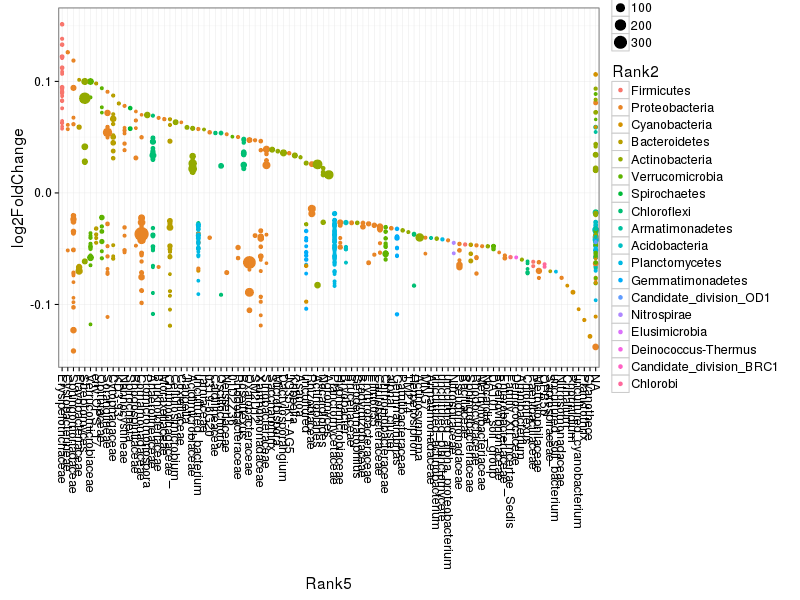

In [55]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
    #ggtitle("2nd order polynomial") +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

In [57]:
%%R
cat(dim(sigtab)[1], "OTUs vary significantly with DAP")

586 OTUs vary significantly with DAP

In [58]:
%%R
sigtab.1 =  arrange(sigtab, padj)
rownames(sigtab.1) = sigtab.1$OTU 
Sig = sigtab.1[, "OTU"] #%>% row.names
#Top20 %>% print

In [59]:
%%R
phy.p = filter_taxa(phy.neg, function(x) max(x) > 100, TRUE)
phy.p = prune_taxa(Sig, phy.p) 
phy.p

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 92 taxa and 55 samples ]
sample_data() Sample Data:       [ 55 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 92 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 92 tips and 91 internal nodes ]


In [60]:
%%R
# phy
sample_data(phy.p)$DAP = as.factor(sample_data(phy.p)$DAP)
dds = phyloseq_to_deseq2(phy.p, ~DAP)
d_dds = DESeq(dds, parallel = TRUE)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: -- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [61]:
%%R
tax_table(phy.p) %>% row.names

 [1] "OTU.284"   "OTU.307"   "OTU.277"   "OTU.681"   "OTU.202"   "OTU.161"  
 [7] "OTU.610"   "OTU.12453" "OTU.630"   "OTU.265"   "OTU.488"   "OTU.100"  
[13] "OTU.102"   "OTU.397"   "OTU.8671"  "OTU.378"   "OTU.188"   "OTU.57"   
[19] "OTU.414"   "OTU.10692" "OTU.141"   "OTU.261"   "OTU.120"   "OTU.2076" 
[25] "OTU.160"   "OTU.621"   "OTU.244"   "OTU.53"    "OTU.33"    "OTU.216"  
[31] "OTU.43"    "OTU.148"   "OTU.808"   "OTU.92"    "OTU.173"   "OTU.7529" 
[37] "OTU.1403"  "OTU.162"   "OTU.10249" "OTU.4"     "OTU.7778"  "OTU.208"  
[43] "OTU.5574"  "OTU.134"   "OTU.1998"  "OTU.11012" "OTU.11302" "OTU.74"   
[49] "OTU.10442" "OTU.5436"  "OTU.9501"  "OTU.10"    "OTU.641"   "OTU.5214" 
[55] "OTU.4040"  "OTU.101"   "OTU.45"    "OTU.23"    "OTU.152"   "OTU.10253"
[61] "OTU.114"   "OTU.49"    "OTU.4378"  "OTU.199"   "OTU.29"    "OTU.107"  
[67] "OTU.10375" "OTU.8916"  "OTU.329"   "OTU.183"   "OTU.25"    "OTU.189"  
[73] "OTU.117"   "OTU.200"   "OTU.516"   "OTU.41"    "OTU.197"   "OTU.63"   

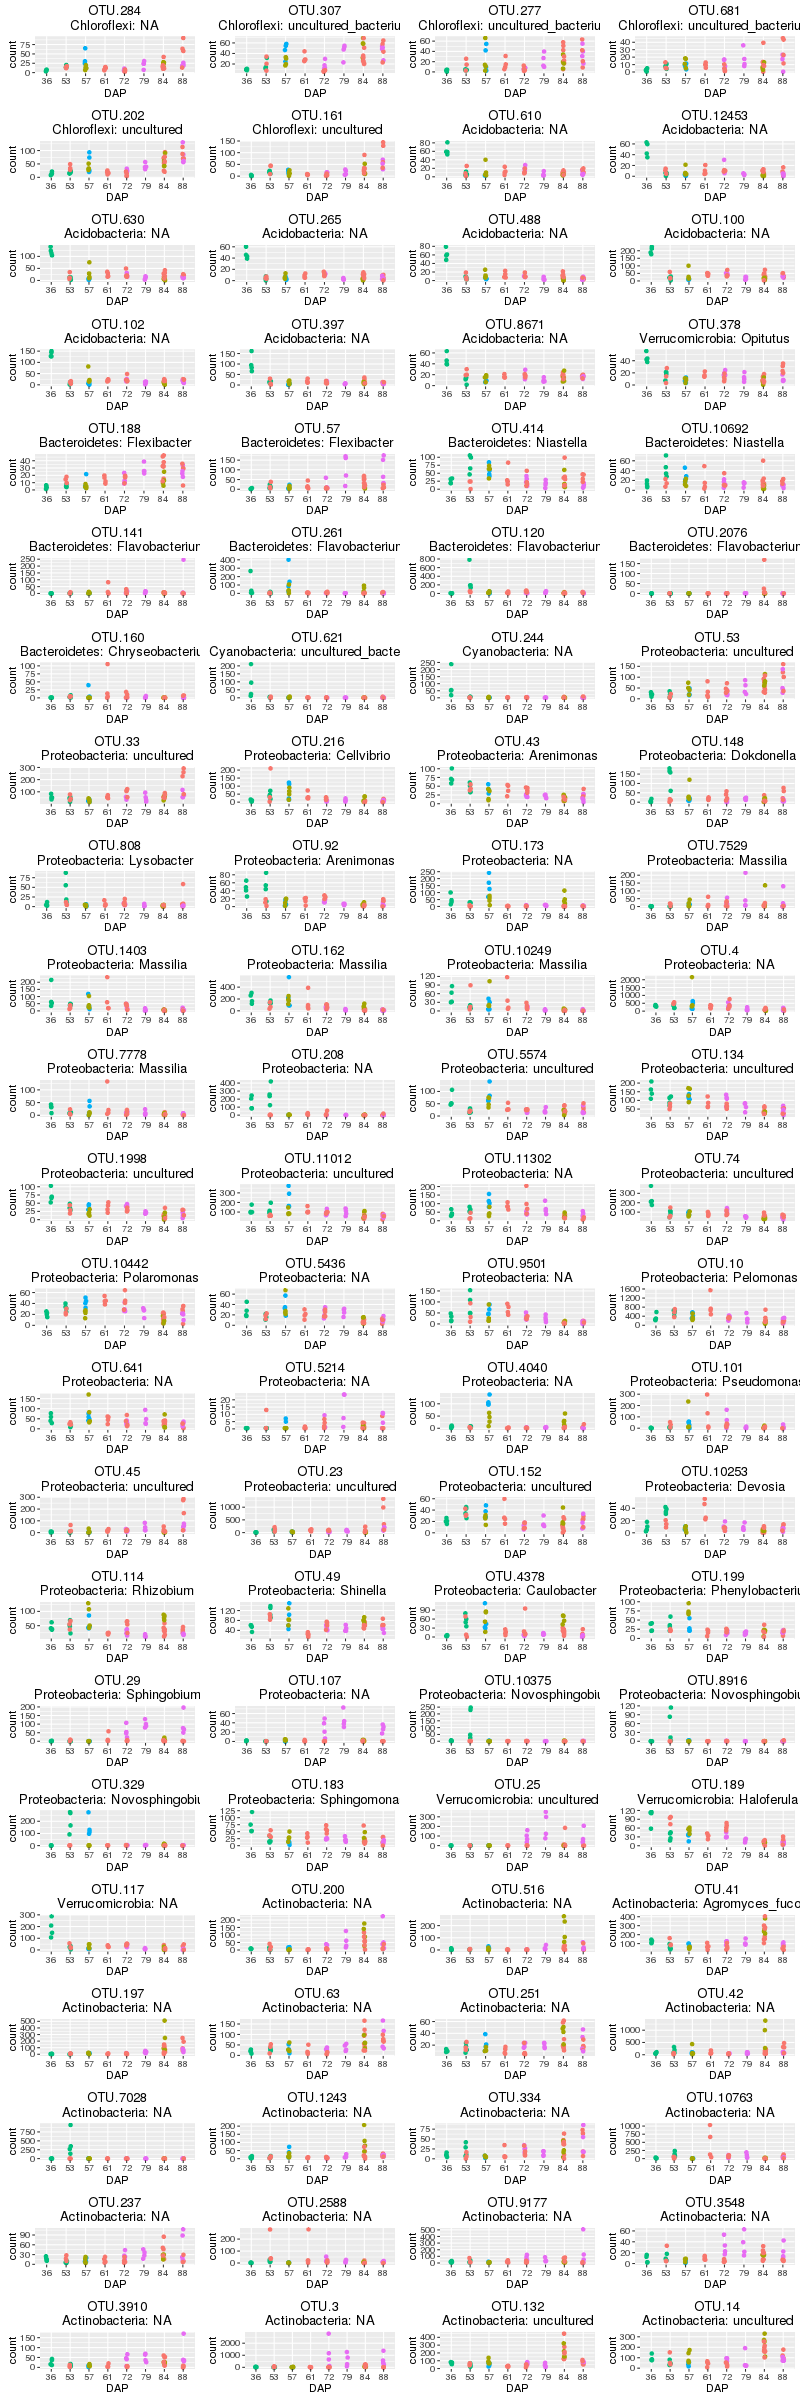

In [63]:
%%R -w 800 -h 2400
p <- list()
Tinfo = as(tax_table(phy.p), "matrix")
ToGraph = tax_table(phy.p) %>% row.names
for (i in ToGraph){
  d = plotCounts(dds, gene=i, intgroup=c("DAP", "Type"), returnData = TRUE)  
    
    
p[[i]] = ggplot(d, aes(x=DAP, y=count, color = Type)) +
  geom_point(position=position_jitter(w=0.1,h=0)) +
  theme(legend.position="none") +
    ggtitle(paste(i, "\n", Tinfo[i, 2], ": ", Tinfo[i, 6], sep = ""))
  }

#legend = get_legend(p[1])
do.call(grid.arrange,c(p, ncol = 4))
#


# Maize

## Maize - PCA of functional traits 

In [ ]:
%%R
# PCA of annuals
M_neg = subset_samples(physeq.Full, Type == "Maize" & Treatment == "Nneg" )
# subset for later deSEQ2 analysis
M_neg_NR = subset_samples(physeq.NR, Type == "Maize" & Treatment == "Nneg" )

sd = as(sample_data(M_neg), "data.frame")
sd$Plant %>% levels %>% print

fit = prcomp(~M_Resid_logB + M_Resid_logN + M_Resid_logCN + d15N, data = sd, 
                na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)




In [ ]:
%%R -w 600 -h 500
S = predict(fit)[,1:3]
M_Fit = cbind(sd, S)
sample_data(M_neg) = M_Fit
sample_data(M_neg_NR) = M_Fit

p = ggplot(M_Fit, aes(PC1, PC2, colour = Plant, 
                       size = 12), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Maize: Biomass, N uptake, C:N ratio, 15N")
p

Notes:
* PC1 positively correlated with plant size and N uptake
* PC2 negatively correlated with plant C:N
* genotype effect is most captured on PC2

## Maize - CAP analysis with Principle components

In [ ]:
%%R
# Calculate w-unifrac distances
registerDoParallel(cores=28)
M_neg.wunif.dist = phyloseq::distance(M_neg, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

M_neg.unif.dist = phyloseq::distance(M_neg, 
                      method = "unifrac", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)



In [ ]:

%%R -w 800 -h 600
### Functional controls Maize, CAP
phy = M_neg
dist = M_neg.wunif.dist

sample_data(phy)$DAP = as.factor(sample_data(phy)$DAP)
unique(sample_data(phy)$DAP) %>% print

#Weighted unifrac CAP

        # CAP ordinate
        cap.ord = ordinate(
            physeq = phy, 
            method = "CAP",
            distance = dist,
            formula = ~ PC1 + PC2 + Condition(Library)
        )

        # CAP plot
        cap.plot <- plot_ordination(
            phy, 
            cap.ord, 
            color = "Plant", 
            axes = c(1,2)
            ) + 
            aes(shape = Type) + 
            geom_point(aes(colour = Plant), 
                alpha= 1, 
                size = 4) + 
            #geom_point(colour = "grey90", 
            #    size = 1.5) + 
            theme_bw(base_size = 16)
            #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
            #    "#1919ff", "darkorchid3", "magenta"))


        # Now add the environmental variables as arrows
        arrowmat <- vegan::scores(cap.ord, display = "bp")


        # Add labels, make a data.frame
        arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

        # Define the arrow aesthetic mapping
        arrow_map <- aes(xend = CAP1, 
            yend = CAP2, 
            x = 0, 
            y = 0, 
            shape = NULL, 
            color = NULL, 
            label = labels)

        label_map <- aes(x = 1.3 * CAP1, 
            y = 1.3 * CAP2, 
            shape = NULL, 
            color = NULL, 
            label = labels)

        arrowhead = arrow(length = unit(0.02, "npc"))

        # Make a new graphic
        p = cap.plot + 
            geom_segment(arrow_map, 
                size = .5, 
                data = arrowdf, 
                color = "gray", 
                arrow = arrowhead
                ) + 
            geom_text(label_map, 
                size = 4,  
                data = arrowdf, 
                show_guide = FALSE)

anova(cap.ord) %>% print
p


CAP model is not significant

## Maize - Deseq of PC2

In [ ]:
%%R
dds = phyloseq_to_deseq2(M_neg_NR, ~Library + PC2)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(A_neg)
            if (!setequal(row.names(res), row.names(res))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

In [ ]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.1)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

In [ ]:
%%R
cat(dim(sigtab)[1], "OTUs vary significantly with PC2")

## Maize - Deseq of PC1

In [ ]:
%%R
dds = phyloseq_to_deseq2(M_neg_NR, ~Library + PC1)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(A_neg)
            if (!setequal(row.names(res), row.names(res))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

In [ ]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.1)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

In [ ]:
%%R
cat(dim(sigtab)[1], "OTUs vary significantly with PC1")